In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

In [3]:
contraceptive_dataset = pd.read_csv('cmc.csv', header = None)
contraceptive_dataset.head()

,0,1,2,3,4,5,6,7,8,9
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [4]:
contraceptive_dataset.columns = ['Wifes age','Wifes education','Husbands education','Number of children ever born',
                                 'Wifes religion', 'Wifes now working?',  'Husbands occupation', 'Standard-of-living index'
                                 , 'Media exposure', 'class']
contraceptive_dataset.head()


,Wifes age,Wifes education,Husbands education,Number of children ever born,Wifes religion,Wifes now working?,Husbands occupation,Standard-of-living index,Media exposure,class
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [5]:
contraceptive_dataset.groupby('class').size()

class
1    629
2    333
3    511
dtype: int64

In [6]:
num_instances = len(contraceptive_dataset)
num_instances

1473

In [7]:
def feature_type(dataset):
    feature_types = {}
    feature_descriptions = {
        'Wifes age': 'numerical',
        'Wifes education': 'categorical',
        'Husbands education': 'categorical',
        'Number of children ever born': 'numerical',
        'Wifes religion': 'categorical',
        'Wifes now working?': 'categorical',
        'Husbands occupation': 'categorical',
        'Standard-of-living index': 'categorical',
        'Media exposure': 'categorical'
    }
    for column in dataset.columns:
        if column == 'class':
          continue
        if column in feature_descriptions:
            feature_types[column] = feature_descriptions[column]
        else:
            raise ValueError(f"{column} does not exist")
    return feature_types

contraceptive_feature_types = feature_type(contraceptive_dataset)
print(contraceptive_feature_types)


{'Wifes age': 'numerical', 'Wifes education': 'categorical', 'Husbands education': 'categorical', 'Number of children ever born': 'numerical', 'Wifes religion': 'categorical', 'Wifes now working?': 'categorical', 'Husbands occupation': 'categorical', 'Standard-of-living index': 'categorical', 'Media exposure': 'categorical'}


In [9]:
class DT:
    def __init__(self, max_depth=20, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def entropy(self, labels):
        label, counts = np.unique(labels, return_counts=True)
        prob = counts / counts.sum()
        return -np.sum(prob * np.log2(prob))

    def information_gain_numerical(self, labels, true_labels, false_labels):
        prob = float(len(true_labels)) / len(labels)
        info_gain = self.entropy(labels) - prob * self.entropy(true_labels) - (1 - prob) * self.entropy(false_labels)
        return info_gain

    def information_gain_categorical(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        avg_entropy_of_partitions = sum((counts[i] / sum(counts)) * self.entropy(labels[partitions == value]) for i, value in enumerate(values))
        return self.entropy(labels) - avg_entropy_of_partitions

    def best_split(self, features, labels, feature_types, min_info_gain=0.01):
        best_gain = -np.inf
        best_feature = None
        best_split_val = None
        m = int(math.sqrt(len(features.columns)))
        m_features = np.random.choice(features.columns, m, replace=False)
        for feature in m_features:
            if feature_types[feature] == "categorical":
                info_gain = self.information_gain_categorical(labels, features[feature])
                if info_gain > best_gain and info_gain >= min_info_gain:
                    best_gain, best_feature = info_gain, feature
                    best_split_val = None
            else:
                sorted_indices = features[feature].sort_values().index
                sorted_labels = labels.loc[sorted_indices]
                sorted_features = features.loc[sorted_indices, feature]
                for i in range(1, len(sorted_features)):
                    if sorted_features.iloc[i] == sorted_features.iloc[i - 1]:
                        continue
                    split_val = (sorted_features.iloc[i] + sorted_features.iloc[i - 1]) / 2
                    true_labels = sorted_labels[sorted_features <= split_val]
                    false_labels = sorted_labels[sorted_features > split_val]
                    info_gain = self.information_gain_numerical(labels, true_labels, false_labels)
                    if info_gain > best_gain and info_gain >= min_info_gain:
                        best_gain, best_feature, best_split_val = info_gain, feature, split_val
        return best_feature, best_split_val

    def build_dt(self, features, labels, feature_types, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or (self.max_depth and depth >= self.max_depth):
            return np.unique(labels)[0]
        else:
            best_feature, best_split_val = self.best_split(features, labels, feature_types)
            if best_feature is None:
                return np.unique(labels)[np.argmax(np.unique(labels, return_counts=True)[1])]
            tree = {best_feature: {}}
            if best_split_val is None:
                for value in np.unique(features[best_feature]):
                    subtree_features = features[features[best_feature] == value].drop(columns=[best_feature])
                    subtree_labels = labels[features[best_feature] == value]
                    subtree = self.build_dt(subtree_features, subtree_labels, feature_types, depth + 1)
                    tree[best_feature][value] = subtree
            else:
                left_indices = features[best_feature] <= best_split_val
                right_indices = features[best_feature] > best_split_val
                left_subtree = self.build_dt(features[left_indices], labels[left_indices], feature_types, depth + 1)
                right_subtree = self.build_dt(features[right_indices], labels[right_indices], feature_types, depth + 1)
                tree[best_feature] = {"<= {:.2f}".format(best_split_val): left_subtree , "> {:.2f}".format(best_split_val): right_subtree}
            return tree

    def fit(self, features, labels, feature_types):
        self.feature_types = feature_types
        self.tree = self.build_dt(features, labels, feature_types)

    def predict(self, dataset):
        predictions = []
        for _, instance in dataset.iterrows():
            prediction = self.predict_helper(instance, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = next(iter(tree))
        if self.feature_types[feature] == 'categorical':
            if instance[feature] in tree[feature]:
                return self.predict_helper(instance, tree[feature][instance[feature]])
        else:
            for key, subtree in tree[feature].items():
                if key.startswith('<='):
                    split_val = float(key.split('<= ')[1])
                    if instance[feature] <= split_val:
                        return self.predict_helper(instance, subtree)
                elif key.startswith('>'):
                    split_val = float(key.split('> ')[1])
                    if instance[feature] > split_val:
                        return self.predict_helper(instance, subtree)
                else:
                    if instance[feature] == key:
                        return self.predict_helper(instance, subtree)
        return np.nan


In [11]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=20, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def bootstrap(self, features, labels):
        num_samples = features.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=True)
        return features.iloc[indices], labels.iloc[indices]

    def fit(self, features, labels, feature_types):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DT(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            features_sample, labels_sample = self.bootstrap(features, labels)
            tree.fit(features_sample, labels_sample, feature_types)
            self.trees.append(tree)

    def predict(self, instances):
        tree_preds = [tree.predict(instances) for tree in self.trees]
        tree_preds = np.array(tree_preds).T
        majority_votes = [self.most_common_label(pred) for pred in tree_preds]
        return np.array(majority_votes)

    def most_common_label(self, pred):
        return Counter(pred).most_common(1)[0][0]

In [12]:
def stratified_cross_validation(features, labels, k=10):
    y = labels.to_numpy()
    label_indices = [np.where(y == label)[0] for label in np.unique(y)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

In [13]:
def unique_labels_filter(true_labels):
    filtered_labels = [label for label in true_labels if not np.isnan(label)]
    return np.unique(filtered_labels)

def mc_cm(true_labels, predictions, num_classes):
    unique_labels = unique_labels_filter(true_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for true, pred in zip(true_labels, predictions):
        if np.isnan(pred):
            continue
        true_idx = label_to_index[true]
        pred_idx = label_to_index.get(pred, -1)
        if pred_idx != -1:
            confusion_matrix[true_idx][pred_idx] += 1
    return confusion_matrix

def metrics_calc(confusion_matrix):
    metrics = {'precision': [], 'recall': [], 'f1': []}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i][i]
        FN = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)
        FP = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        TN = sum(sum(confusion_matrix[j][k] for k in range(len(confusion_matrix)) if k != i) for j in range(len(confusion_matrix)) if j != i)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
    for metric in metrics:
        metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
    return metrics


In [14]:
def evaluate_rf(features, labels, feature_types, k=10, ntree=1):
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    pairs = stratified_cross_validation(features, labels, k=k)
    num_classes = len(np.unique(labels))
    for train_indices, test_indices in pairs:
        features_train, labels_train = features.iloc[train_indices], labels.iloc[train_indices]
        features_test, labels_test = features.iloc[test_indices], labels.iloc[test_indices]
        ensemble = RandomForest(n_trees=ntree, max_depth=10, min_samples_leaf=1)
        ensemble.fit(features_train, labels_train, feature_types)
        predictions = ensemble.predict(features_test)
        confusion_matrix = mc_cm(labels_test.to_numpy(), predictions, num_classes)
        metrics = metrics_calc(confusion_matrix)
        accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / sum(sum(row) for row in confusion_matrix)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(metrics['precision'])
        scores['recall'].append(metrics['recall'])
        scores['f1'].append(metrics['f1'])
    avg_perf = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_perf


In [15]:
contraceptive_features = contraceptive_dataset.drop('class', axis=1)
contraceptive_labels = contraceptive_dataset['class']

In [16]:
average_performance_1 = evaluate_rf(contraceptive_features, contraceptive_labels, contraceptive_feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_1}")


Metrics for a value of ntree = 1: {'accuracy': 0.46731036568019846, 'precision': 0.4702397706085125, 'recall': 0.45917038070016325, 'f1': 0.4472851566639413}


In [18]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(contraceptive_features, contraceptive_labels, contraceptive_feature_types, k=10, ntree=ntree)
    metrics_results['ntree'].append(ntree)
    metrics_results['accuracy'].append(average_performance['accuracy'])
    metrics_results['precision'].append(average_performance['precision'])
    metrics_results['recall'].append(average_performance['recall'])
    metrics_results['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")


Metrics for a value of ntree = 1: {'accuracy': 0.4410237630221481, 'precision': 0.4282943097451808, 'recall': 0.43060226195695905, 'f1': 0.41321952806136275}
Metrics for a value of ntree = 5: {'accuracy': 0.4588052302837104, 'precision': 0.44334733258782755, 'recall': 0.4360401190979939, 'f1': 0.4243878845769843}
Metrics for a value of ntree = 10: {'accuracy': 0.4847859617248497, 'precision': 0.4709109544954727, 'recall': 0.44569194071091606, 'f1': 0.43835745750812755}
Metrics for a value of ntree = 20: {'accuracy': 0.4983035730238215, 'precision': 0.48656736245627147, 'recall': 0.46295503990001147, 'f1': 0.4578134201734329}
Metrics for a value of ntree = 30: {'accuracy': 0.5003540204350564, 'precision': 0.4948705119733985, 'recall': 0.46093877483820556, 'f1': 0.45571807832576294}
Metrics for a value of ntree = 40: {'accuracy': 0.49966399511507803, 'precision': 0.4841613167440473, 'recall': 0.46206784816841734, 'f1': 0.4570662472639035}
Metrics for a value of ntree = 50: {'accuracy': 0

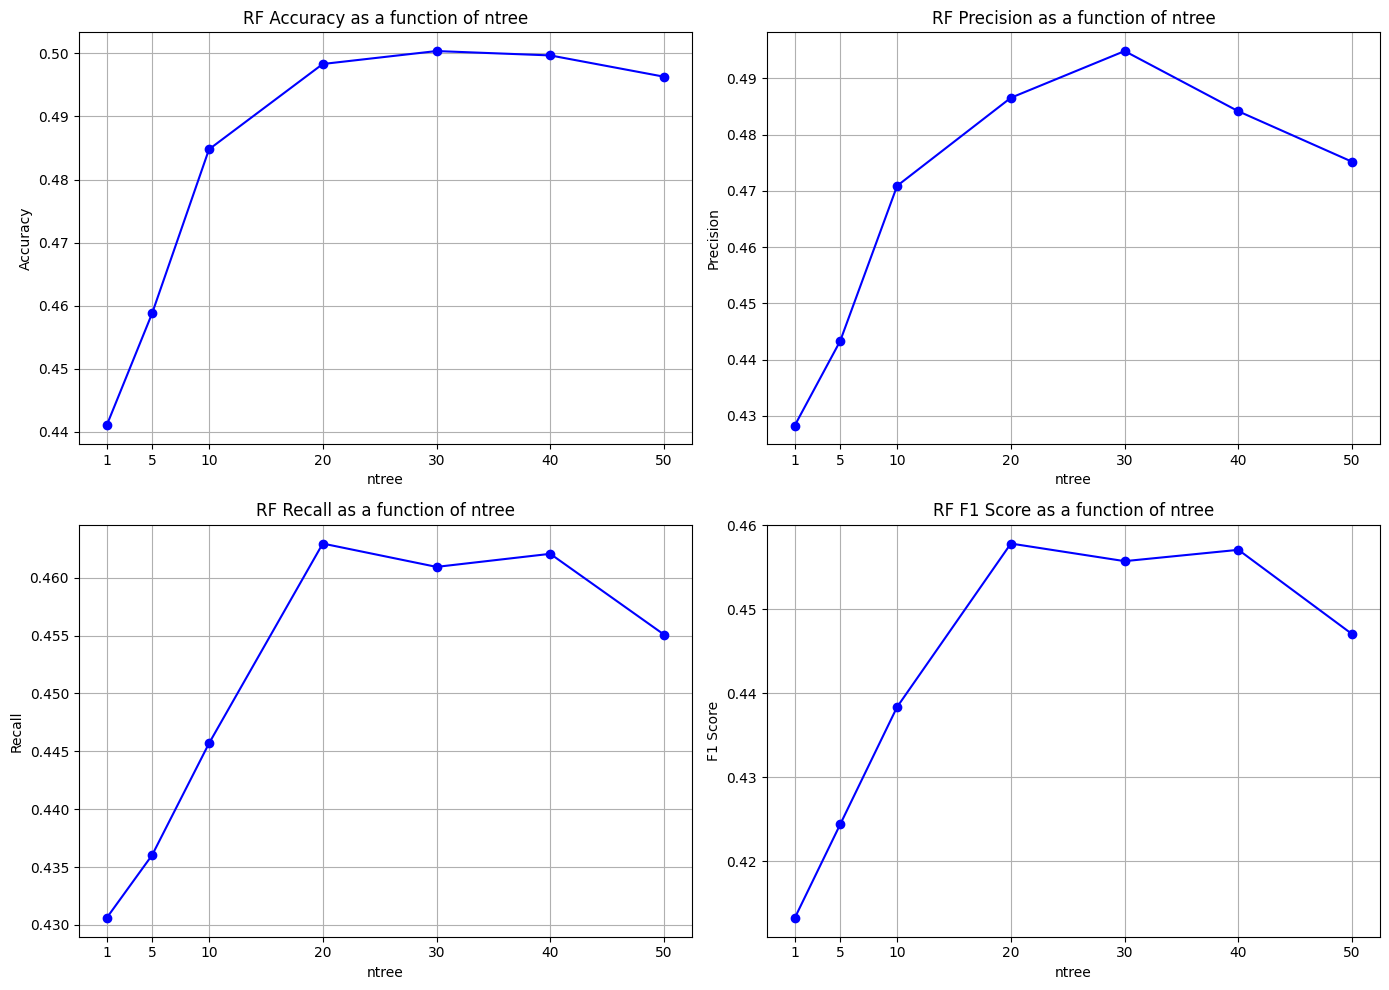

In [19]:
def plot(metrics):
    plt.figure(figsize=(14, 10))
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], start=1):
        plt.subplot(2, 2, i)
        plt.plot(metrics['ntree'], metrics[metric], marker='o', linestyle='-', color='b')
        plt.title(f'RF {titles[i-1]} as a function of ntree')
        plt.xlabel('ntree')
        plt.ylabel(titles[i-1])
        plt.xticks(metrics_results['ntree'])
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot(metrics_results)

**4.** For each metric being evaluated (and for each dataset), discuss which value of ntree you would
select if you were to deploy this classifier in real life. Explain your reasoning.

The Contraceptive Method Choice Dataset is a hard dataset to deal with because of the combination of both numerical and categorical attributes. The process of building the DT is way more complex and requires careful handling. With 1473 instances and 3 classes this dataset offers a complex scenario. My code took a long time to run and the metrics's performance isn't good enough in my opinion for real life deployment.

When evaluating the performance metrics for various values of ntree we observe gradual improvements in accuracy, precision, recall, and F1 score as the number of trees increases.

Accuracy was observed to peak at ntree = 30 with a score of 0.5. After this point, increasing the number of trees seem to affect accuracy in a negative way (decreasing). The value of accuracy for ntree = 30 is 0.5 which is really close to the the one for ntree = 20, both accuracies are low and I wouldn't deploy this model to classify this dataset but for ntree = 20 it takes less running time and computational resources for the same bad performance. Hence, I would go for ntree = 20 if I had to choose one of the worst scenarios.

Precision was observed to peak at ntree = 30 with a score of 0.49. Precison measures how accurate the predicitons are when the model predicts a specific class. This metric is important when the consequences of FP  are significant. I would also go for ntree = 10 or 20 here in this case since the model's taking so much time and the performance is bad either way 0.47 and 0.50 are basically the same in this case.

Recall was at its maximum at ntree = 20 with a score of 0.46. Recall captures all relevant instances of a given class. I would choose this ntree = 20 if I were to deploy this model since it aligns with the performance of the other metrics too and it doesn't require more running time compared to adding more trees.

The F1 score, which balances precision and recall, peaked at ntree = 20 with a score of 0.457. Hence, ntree = 20 is indeed the best choice in this case: it ensures a balanced and fair tradeoff between precision and recall.

A higher number of trees increases the model's complexity, which can lead to longer training times and increased computational resources. It may not be effective to increase the number of trees further than ntree = 20 given the bad perfomance overall. We should try to use a different dataset or use better attributes, maybe try a different algorithm etc. The mix of numerical and categorical data in this dataset seems to be challenging for the model. The dataset also contains class imbalance, with varying numbers of instances across the three contraceptive method types. This imbalance skews the model's performance affecting precision and recall specifically. 

Given these considerations, I would select ntree = 20 for deploying this classifier. This choice represents a compromise between ensuring model simplicity and maintaining reasonable accuracy and other performance metrics keeping in mind the complexity of mixed attributes and the class imbalance, aiming for a model that performs reasonably across different metrics.


**5.** Discuss (on a high level) which metrics were more directly affected by changing the value of
ntree and, more generally, how such changes affected the performance of your algorithm. For
instance: was the accuracy of the random forest particularly sensitive to increasing ntree past a
given value? Was the F1 score a “harder” metric to optimize, possibly requiring a significant
number of trees in the ensemble? Is there a point beyond which adding more trees does not
improve performance—or makes the performance worse?


Accuracy generally showed improvement as the number of trees increased indicating that the ensemble method benefits from the increase in decision trees. However, it reached its max for ntree = 30 reaching a threshold beyond which additional trees do not contribute to a better results or generalization. There is a limit to the benefits of adding more trees.

Precision reached a peak at ntree value of 30 but did not consistently improve with more trees. Precision can be particularly sensitive to class imbalance. In cases where one class dominates the model might predict the majority class more frequently. This behavior was observed as precision peaked at certain points but did not maintain a steady improvement pattern highlighting the nuanced impact of class distribution on model evaluation.

Recall showed a drop at certain ntree values compared to precision. Recall measures how many relevant instances are selected. The observed drop suggests that as the model complexity increased it may have become overly specific to the training data failing to generalize well to unseen data and thus missing relevant instances. This metric's sensitivity to the class imbalance was noticeable too as the model attempted to correct for overpredicting the majority class. We can say its ability to identify all instances of less represented classes decreased leading to lower recall scores.

F1 Score aiming to balance precision and recall showed that trying to optimize one metric affected the other. This shows the challenge of achieving a model that performs well across all aspects. The F1 score did not follow a straightforward improvement with more trees, due to the trade-off between recall and precision. The complexity added by more trees did not lead to better performance it was more complicated in this case.

In summary, the metrics did not uniformly respond to increases in ntree reflecting the Random Forest model's complex dynamics when applied to a dataset with both numerical and categorical attributes and class imbalance. 